# Introduction to this notebook
In [this notebook](https://www.kaggle.com/code/matthiaskleine/read-german-temperature-data-1990-2021) we described the download and transformation of historical weather data from Germany. The source of the data is the Climate Data Center (CDC) of Deutscher Wetterdienst (DWD, engl. German Meteorological Service). For more information on the original data, please consult the referenced notebook.

In the notebook at hand, the original data are inspected, cleaned and filtered. We have the following aims:
* Inspect the **distribution** of temperature measurements over time.
* **Clean** up the data (fill gaps in the time series and remove outliers).
* Find a **selection** of weather stations that provide a (nearly) identical distribution over as long a period as possible.
* Provide this selection as a **new file in the dataset** (/kaggle/input/german-temperature-data-1990-2021/german_temperature_data_1996_2021_from_selected_weather_stations/german_temperature_data_1996_2021_from_selected_weather_stations.csv).
* By a simple OLS **linear regression** over the data of the selected weather stations, get a first impression of the temperature increase per year in Germany.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/german-temperature-data-1990-2021/zehn_min_tu_Beschreibung_Stationen.txt
/kaggle/input/german-temperature-data-1990-2021/DESCRIPTION_obsgermany_climate_10min_tu_historical_en.pdf
/kaggle/input/german-temperature-data-1990-2021/german_temperature_data_1996_2021_from_selected_weather_stations/german_temperature_data_1996_2021_from_selected_weather_stations.csv
/kaggle/input/german-temperature-data-1990-2021/german_temperature_data_1990_2021/german_temperature_data_1990_2021.csv


# Spoiler: the final regression result
For the impatient the final result (the temperature increase measured by 55 weather stations from 1996 to 2021) of this notebook is shown in the regression plot below. 

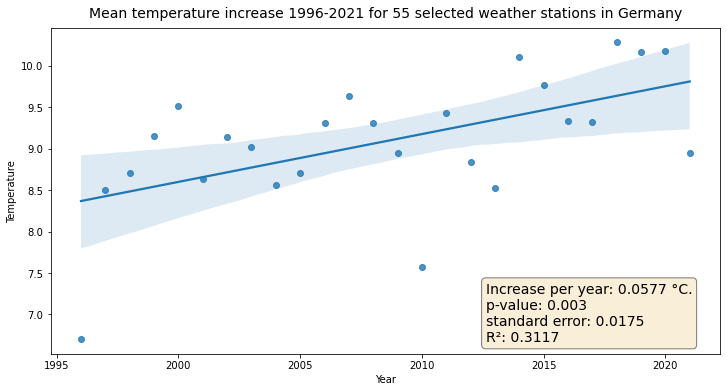

In [3]:
def plot_result(df):
    number_of_stations = df.shape[1]
    
    df_yearly_mean = df.groupby(df.index.year).mean()
    df_total_yearly_mean = df_yearly_mean.mean(axis=1)
    df_total_yearly_mean = df_total_yearly_mean.reset_index()
    df_total_yearly_mean.columns = ["Year", "Temperature"]
    
    slope, intercept, r, p, se = stats.linregress(df_total_yearly_mean.Year, 
                                                  df_total_yearly_mean.Temperature)
    
    plt.figure(figsize=(12, 6))
    sns.regplot(data=df_total_yearly_mean, x="Year", y="Temperature", ci=95)

    plt.title("Mean temperature increase 1996-2021 for " + str(number_of_stations) 
              + " selected weather stations in Germany",
              fontdict={"size": 14},
              pad=10)

    comment =           "Increase per year: " + str(round(slope, 4)) + " °C.\n"
    comment = comment + "p-value: " + str(round(p, 4)) + "\n"
    comment = comment + "standard error: " + str(round(se, 4)) + "\n"
    comment = comment + "R²: " + str(round(r**2, 4))

    ax = plt.gca()
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5, edgecolor='black')
    ax.text(0.65, 0.22, comment, transform=ax.transAxes, fontsize=14, 
            verticalalignment='top', bbox=props);

result_file = '/kaggle/input/german-temperature-data-1990-2021/german_temperature_data_1996_2021_from_selected_weather_stations/german_temperature_data_1996_2021_from_selected_weather_stations.csv' 

df = pd.read_csv(result_file, index_col="MESS_DATUM")
df.index = pd.to_datetime(df.index, format="%Y-%m-%d %H:%M:%S")

plot_result(df)
del(df)

# Read in data and prepare dataframe for usage

In [4]:
input_file = "/kaggle/input/german-temperature-data-1990-2021/german_temperature_data_1990_2021/german_temperature_data_1990_2021.csv"

In [5]:
df = pd.read_csv(input_file, index_col="MESS_DATUM")
df.index = pd.to_datetime(df.index, format="%Y-%m-%d %H:%M:%S")

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1682298 entries, 1990-01-01 00:00:00 to 2021-12-31 23:50:00
Columns: 513 entries, 3 to 19172
dtypes: float64(513)
memory usage: 6.4 GB


In [7]:
# Expectation: 4683932799.3
df.sum().sum()

4683932799.3

In [8]:
df.head()

,3,44,71,73,78,91,96,131,142,150,...,13713,13776,13777,13965,15000,15207,15444,15555,19171,19172
MESS_DATUM,,,,,,,,,,,,,,,,,,,,,
1990-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-01 00:10:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-01 00:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-01 00:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-01 00:40:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Check and correct for missing and unexpected values
The data contain a time series with 10 minute frequency starting from 1990-01-01  up to 2021-12-31.

We look for two kinds of problems:
* We check, if there are any values missing (and how many and when).
* We look for values that are not fitting in the 10 minute frequency and are thus unexpected.


In [9]:
# we set the complete range of 10 minute values and create a dataframe from it
complete_range = pd.date_range(df.index.min(), df.index.max(), freq="10min")
complete_df = pd.DataFrame(index=complete_range)
df = df.asfreq("10min")
print("Length of cleaned range: " + str(len(df)))
print("Length of correct range: " + str(len(complete_df)))

Length of cleaned range: 1683072
Length of correct range: 1683072


In [10]:
# check for missing or unexpected values
missing_entries = complete_df.index.difference(df.index)
unexpected_entries = df.index.difference(complete_df.index)
print("Number of    missing values: " + str(len(missing_entries)))
print("Number of unexpected values: " + str(len(unexpected_entries)))

Number of    missing values: 0
Number of unexpected values: 0


In [11]:
# Expectation is still: 4683932799.3
df.sum().sum()

4683932799.3

In [12]:
# cleanup
del(complete_range)
del(complete_df)

# Yearwise distribution of measurements
The dataset contains measurements of 513 weather stations.

However, to calculate and compare yearly mean values, we have to make sure that the distribution is the same for all years.

We therefore analyse and visualize the distribution per year for all weather stations.

In [13]:
yearly_count = df.groupby(df.index.year).count()

In [14]:
yearly_count.head(10)

,3,44,71,73,78,91,96,131,142,150,...,13713,13776,13777,13965,15000,15207,15444,15555,19171,19172
MESS_DATUM,,,,,,,,,,,,,,,,,,,,,
1990,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1991,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1992,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1993,30428,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1994,48299,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1995,31056,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1996,51163,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1997,51783,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1998,51379,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
# Make the plotting functionality of the following plot available for later plots.

def annotation_box(annotation, x, y, alpha=1):
    ax = plt.gca()
    props = dict(boxstyle='round', facecolor='white', alpha=alpha, edgecolor='black')
    ax.text(x, y, annotation, transform=ax.transAxes, fontsize=18, 
            verticalalignment='top', bbox=props)

def plot_measurements(df, ax, granularity="year", figsize=(20,10)):
    fig = plt.gcf()
    fig.set_size_inches(*figsize)
    sns.heatmap(df, ax=ax)
    ax.set_title("Number of measurements per weather station and " + granularity, 
                 fontdict={"size" : 20}, pad=20)
    ax.set_xlabel("Weather stations")
    ax.set_ylabel(granularity.title());

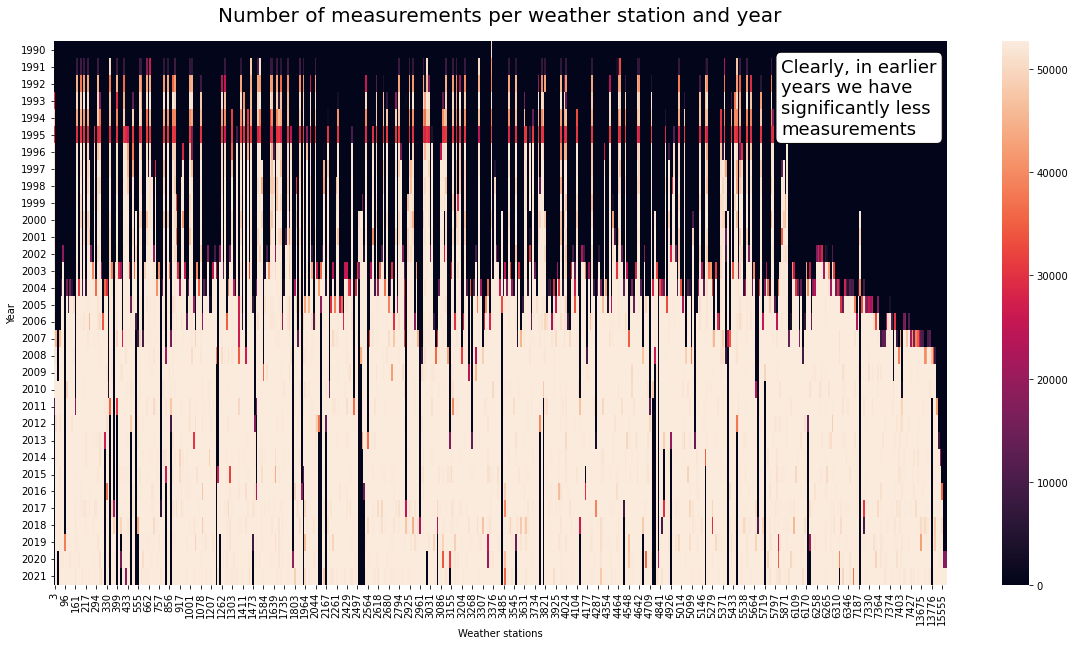

In [16]:
plot_measurements(yearly_count, plt.gca())

annotation = "Clearly, in earlier\nyears we have\nsignificantly less\nmeasurements"
annotation_box(annotation, x = 0.815, y = 0.97)

# Find a subset of weather stations that are approximately identically distributed

To find such a subset, we:
* start searching from 1993 (because earlier years obviously only contain data from a view weather stations
* try to maximize a lower limit of measurments per year/station for as many stations as possible
* plot the number of stations for a range of limits from 1000 to 40000

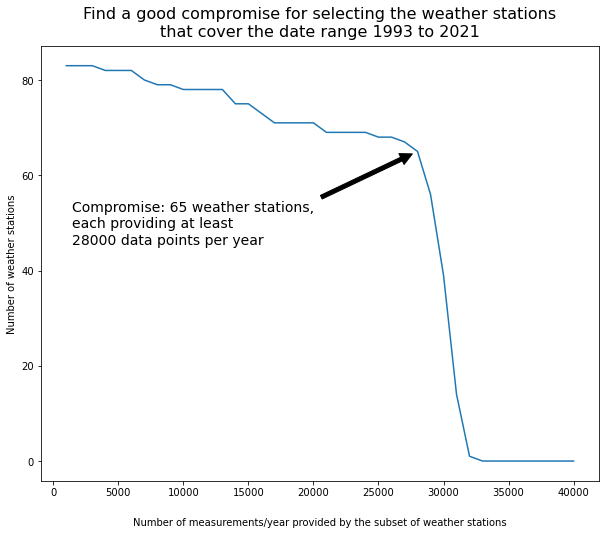

In [17]:
# find a good limit for the minimum values that each weather station has to provide per year
result_map = {}

for limit in range(1000, 40001, 1000):
    stationen = []
    for station in yearly_count.columns:
        # we want to use the station
        use_station = True

        # let's see if it provides enough data
        for year in range(1993, 2022):
            station_count_per_year = yearly_count.loc[year, station]
            if station_count_per_year < limit:
                use_station = False
                break

        if use_station:
            stationen.append(station)

    result_map[limit] = len(stationen)

df_result_map = pd.DataFrame(result_map.values(), index=result_map.keys())

# visualize the results
plt.figure(figsize=(10,8))
plt.plot(df_result_map)
plt.gca().annotate('Compromise: 65 weather stations,\neach providing at least \n28000 data points per year',
            xy=(28000, 65),
            xytext=(0.1, 0.5),
            size=14,
            textcoords='figure fraction',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='left',
            verticalalignment='bottom')
plt.xlabel("Number of measurements/year provided by the subset of weather stations", 
           labelpad=20)
plt.ylabel("Number of weather stations")
plt.title("Find a good compromise for selecting the weather stations\nthat cover the date range 1993 to 2021", 
          fontdict={"size" : "16"}, pad=10)

# cleanup
del(df_result_map)
del(result_map)
del(stationen)

## Select and analyze the 65 weather stations that provide at least 28.000 measurements

In [18]:
# so let's do this selection
limit = 28000
stationen = []
for station in yearly_count.columns:
    use_station = True

    for year in range(1993, 2022):
        station_count_per_year = yearly_count.loc[year, station]
        if station_count_per_year < limit:
            use_station = False
            break

    if use_station:
        stationen.append(station)

In [19]:
selection = df.loc['1993':, stationen].copy()

In [20]:
selection.shape

(1525248, 65)

In [21]:
yearly_count_selection = selection.groupby(selection.index.year).count()

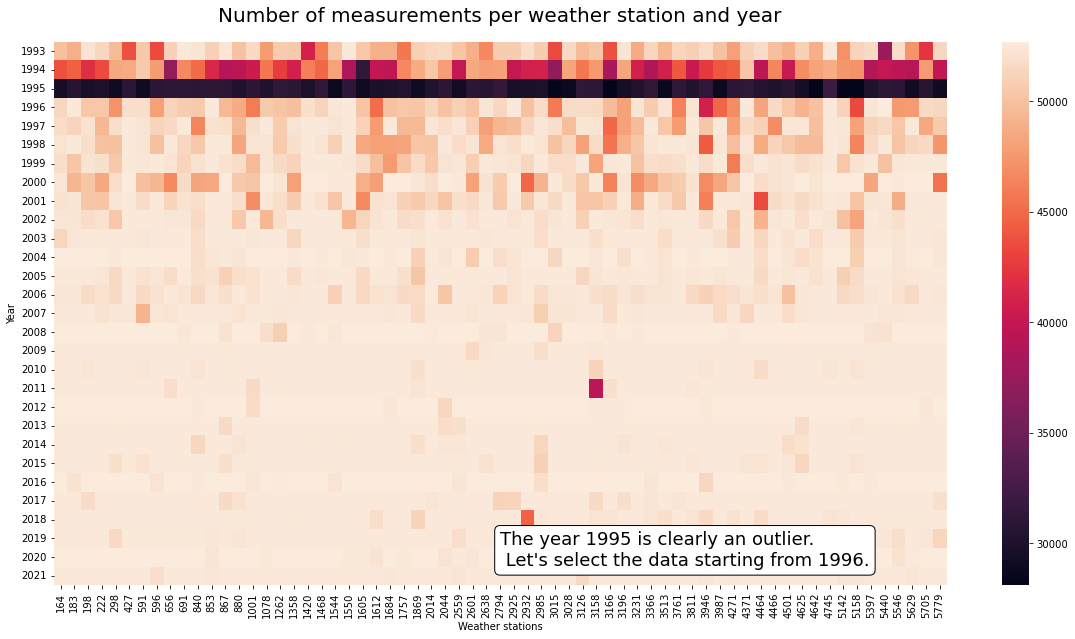

In [22]:
plot_measurements(yearly_count_selection, plt.gca())

annotation = "The year 1995 is clearly an outlier.\n Let's select the data starting from 1996."
annotation_box(annotation, 0.5, 0.1)

In [23]:
selection = selection.loc['1996':, stationen].copy()

In [24]:
selection.shape

(1367568, 65)

In [25]:
yearly_count_selection = selection.groupby(selection.index.year).count()

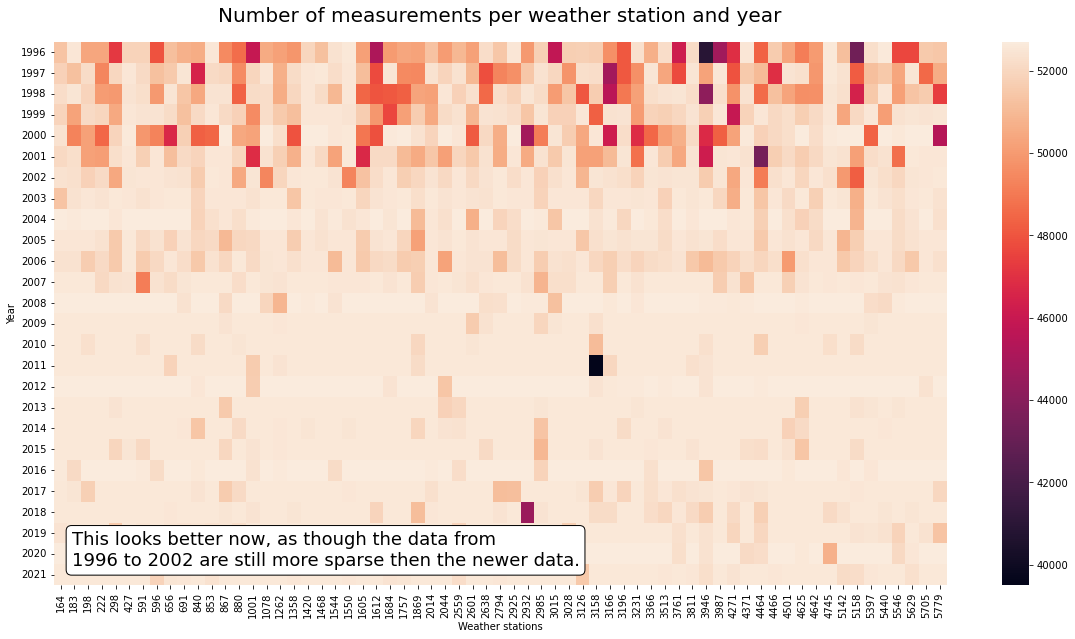

In [26]:
plot_measurements(yearly_count_selection, plt.gca())

annotation = "This looks better now, as though the data from\n1996 to 2002 are still more sparse then the newer data."
annotation_box(annotation, 0.02, 0.1)

Further manual inspection of the heatmap shows that the following list of weather stations provides the most sparse data of the selected weather stations, so we exclude these stations manually.

In [27]:
exclude_list = ["1612", "2932", "3158", "3946", "3166", "4271", "4464", "5158", "5779"]
remaining_stations = [x for x in selection.columns if x not in exclude_list]
selection = selection[remaining_stations]

In [28]:
selection.shape

(1367568, 56)

In [29]:
yearly_count_selection = selection.groupby(selection.index.year).count()

In [30]:
def calculate_max_possible_measurements_per_year(selection):
    selected_range = pd.date_range(selection.index.min(), selection.index.max(), freq="10min")
    df_max = pd.DataFrame(index=selected_range)
    df_max["count"] = 1
    df_max_year = df_max.groupby(df_max.index.year).count()
    return df_max_year["count"].max()

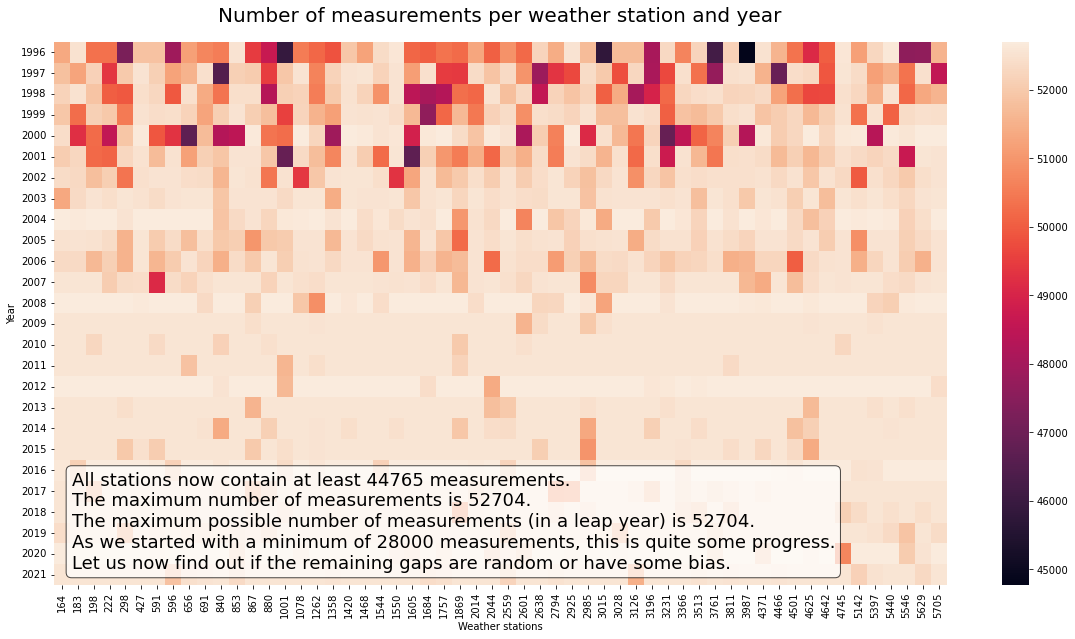

In [31]:
plot_measurements(yearly_count_selection, plt.gca())

annotation = "All stations now contain at least " \
             + str(yearly_count_selection.min().min()) + " measurements.\n"
annotation = annotation + "The maximum number of measurements is " \
             + str(yearly_count_selection.max().max()) + ".\n"
annotation = annotation + "The maximum possible number of measurements (in a leap year) is " \
             + str(calculate_max_possible_measurements_per_year(selection)) + ".\n"
annotation = annotation + "As we started with a minimum of 28000 measurements, this is quite some progress.\n"
annotation = annotation + "Let us now find out if the remaining gaps are random or have some bias."

annotation_box(annotation, 0.02, 0.21, alpha=0.7)

## Find out if the remaining gaps have some bias
We want to know if the differences in the number of measurements are distributed randomly of if the show some bias.

Do some of the weather stations have more measurements for selected years, months, weeks, hours or minutes?

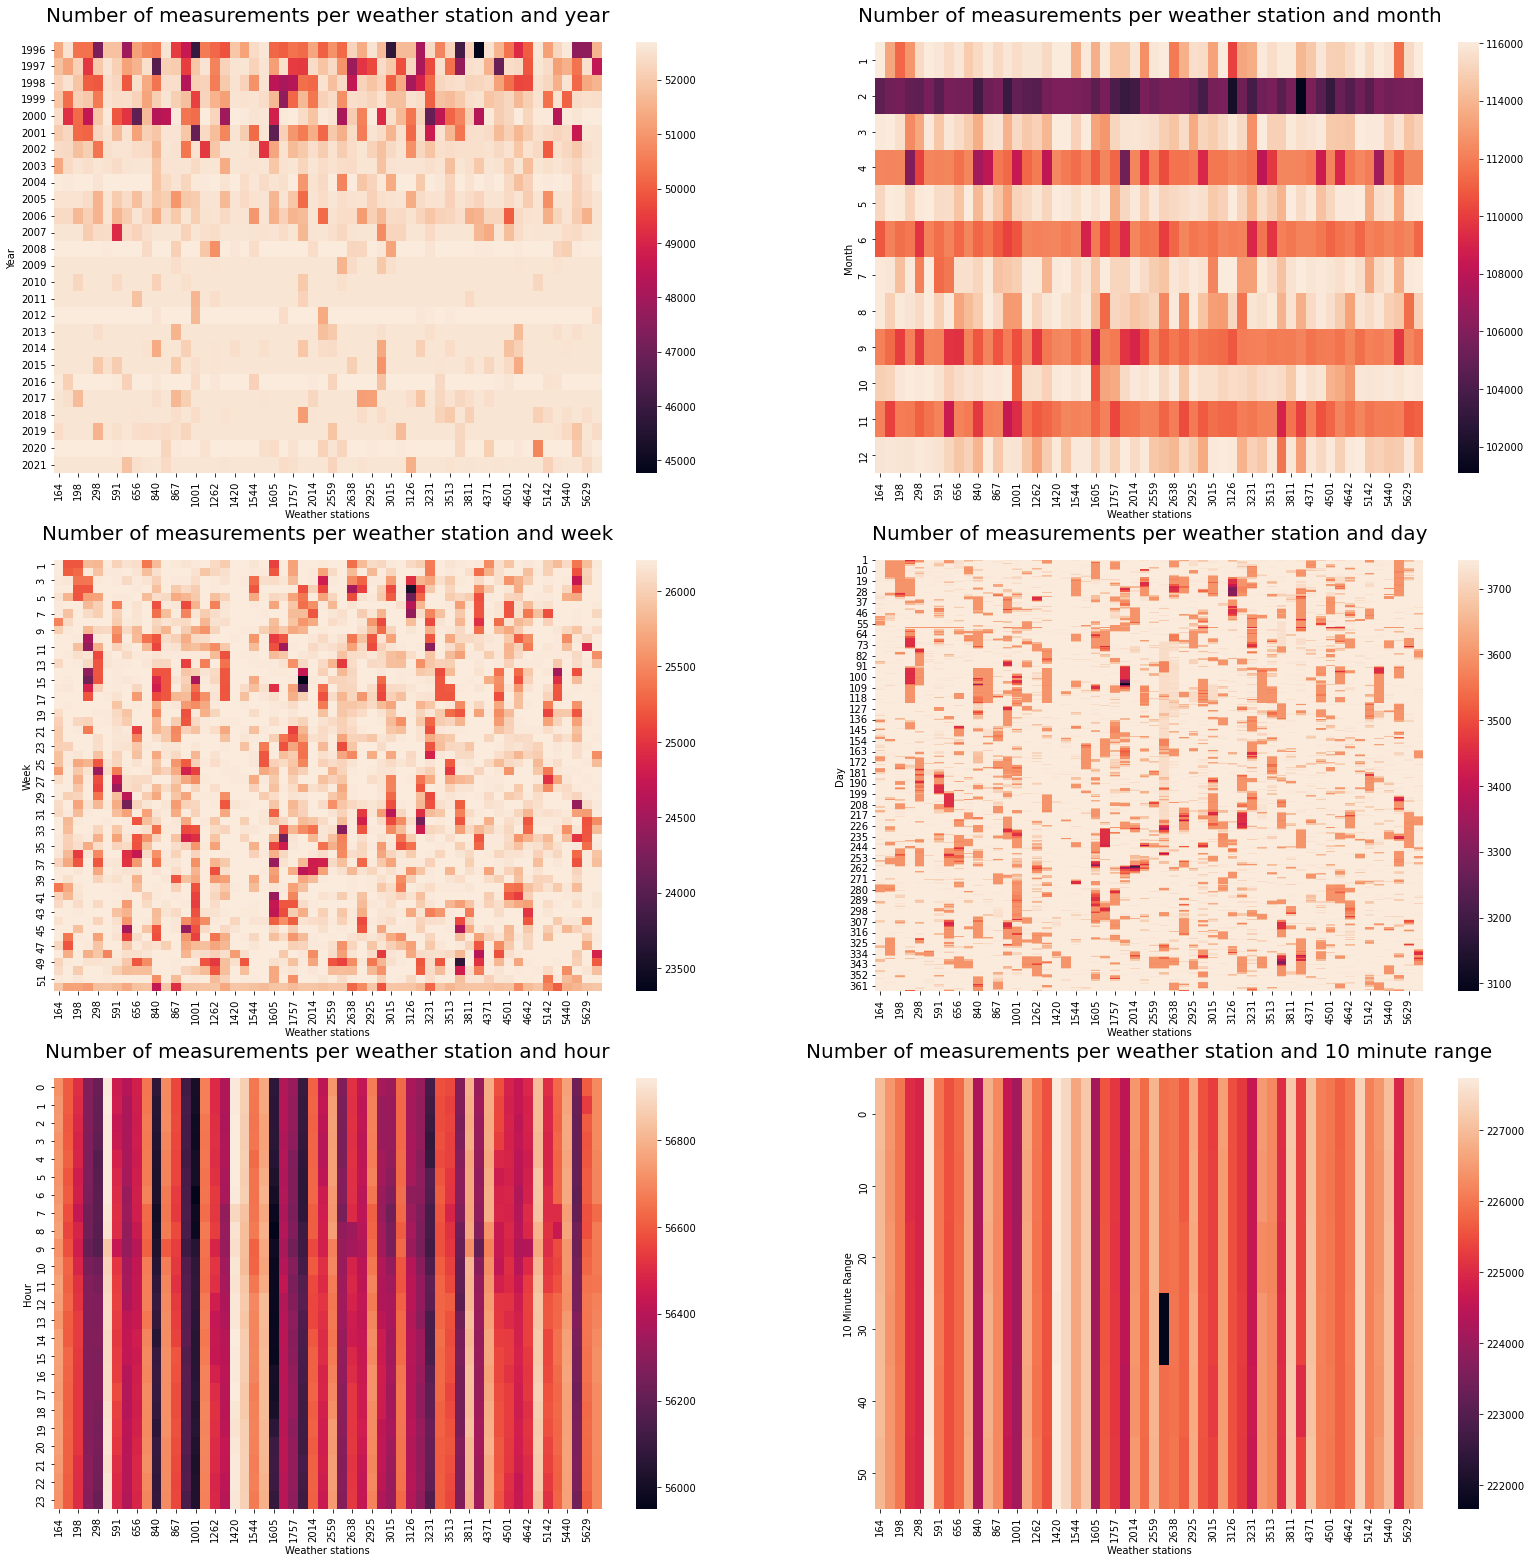

In [32]:
fig, axes = plt.subplots(3, 2)

yearly_count_selection = selection.groupby(selection.index.year).count()
monthly_count_selection = selection.groupby(selection.index.month).count()
weekly_count_selection = selection.groupby(selection.index.isocalendar().week).count()
hourly_count_selection = selection.groupby(selection.index.hour).count()
minutewise_count_selection = selection.groupby(selection.index.minute).count()
daily_count_selection = selection.groupby(selection.index.dayofyear).count()

figsize = (27, 27)

plot_measurements(yearly_count_selection, ax=axes[0,0], granularity="year", figsize=figsize);
plot_measurements(monthly_count_selection, ax=axes[0,1], granularity="month", figsize=figsize);

# We exclude calender week 53, which is rare and short.
# So we get more differentiated results for weeks 1-52.
plot_measurements(weekly_count_selection.loc[1:52], ax=axes[1,0], granularity="week", figsize=figsize);

# We exclude calender day of year 366, for the same reasons as calendar week 53.
plot_measurements(daily_count_selection.loc[1:365], ax=axes[1,1], granularity="day", figsize=figsize);

plot_measurements(hourly_count_selection, ax=axes[2,0], granularity="hour", figsize=figsize);
plot_measurements(minutewise_count_selection, ax=axes[2,1], granularity="10 minute range", figsize=figsize);

## Interpretation of the previous plots
The distributions of the data with regard to the time component (year, month, week, day, hour, minute) show the following patterns:
* **year**: data are more sparse in earlier years
* **month**: shows the expected differences due to the length of months
* **week**: more or less randomly distributed differences
* **day**: more or less randomly distributed differences
* **hour**: when there are differences between weather stations, these apply more or less to all measurements during the day
* **minute**: the same as for hour, with the exception of one weather station showing an anomaly (2601)

Weather station 2601 will therefore be excluded from the selection in the next step.

In [33]:
selection.drop(columns=["2601"], inplace=True)

# Detect and cleanup outliers

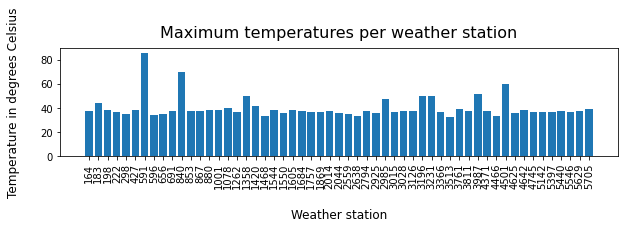

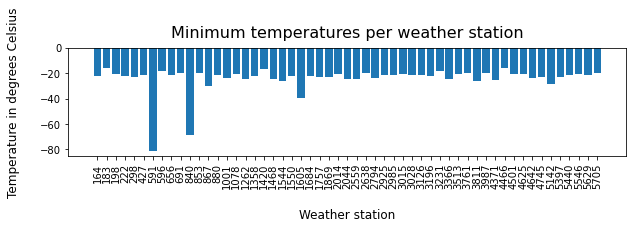

In [34]:
def plot_min_max(sel, min_or_max):
    plt.figure(figsize=(10,2))

    sel.columns = [min_or_max]
    plt.bar(sel.index, sel[min_or_max])
    plt.xticks(rotation=90);
    plt.title(min_or_max + " temperatures per weather station", fontdict={"size" : 16}, 
              pad=10)
    plt.ylabel("Temperature in degrees Celsius", fontsize=12, labelpad=20)
    plt.xlabel("Weather station", fontsize=12, labelpad=20);


plot_min_max(selection.max().to_frame(), "Maximum")
plot_min_max(selection.min().to_frame(), "Minimum")

## Finding a limit for "probable measurement errors"
The number of outliers depends on the limit that we choose for a "probable measurement error". We therefore check the following:
* try different limits (ranging vom 40 to 99 degrees Celsius and from -35 to -99 degrees Celsius)
* count the number of outliers for each limit

In [35]:
result_hot = {}
for temperature in range(40, 100):
    result_hot[temperature] = 0
    for station in selection.columns:
        over_limit = selection[selection[station] > temperature]
        result_hot[temperature] = result_hot[temperature] + len(over_limit)

df_hot = pd.DataFrame(result_hot.values(), index=result_hot.keys())

result_cold = {}
for temperature in range(-35, -100, -1):
    result_cold[temperature] = 0
    for station in selection.columns:
        under_limit = selection[selection[station] < temperature]
        result_cold[temperature] = result_cold[temperature] + len(under_limit)

df_cold = pd.DataFrame(result_cold.values(), index=result_cold.keys())

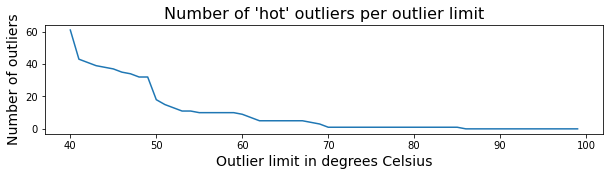

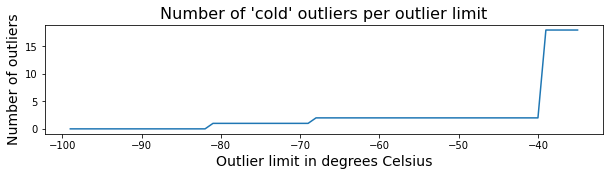

In [36]:
def plot_outliers(df_tmp, hot_or_cold):
    plt.figure(figsize=(10, 2))
    plt.plot(df_tmp.index, df_tmp[0])
    plt.title("Number of '" + hot_or_cold + "' outliers per outlier limit", 
              fontdict={"size" : 16})
    plt.xlabel("Outlier limit in degrees Celsius", fontsize=14)
    plt.ylabel("Number of outliers", fontsize=14);

plot_outliers(df_hot, "hot")
plot_outliers(df_cold, "cold");

## Interpretation of the outlier plots
We can interpret temperature values >= 50 and <= -30 degrees Celsius as probable measurement errors.
These will be deleted from the selection in the next step.

In [37]:
for station in selection.columns:
    selection.loc[:, station] = np.where(selection.loc[:, station] >= 50.0, 
                                         np.nan, selection.loc[:, station])
    selection.loc[:, station] = np.where(selection.loc[:, station] <= -30.0, 
                                         np.nan, selection.loc[:, station])

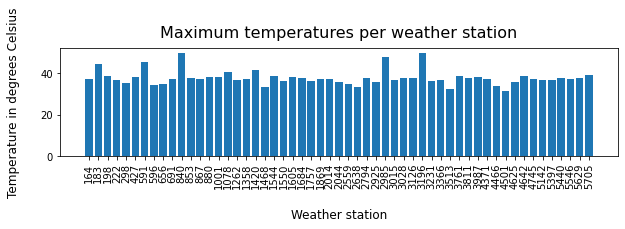

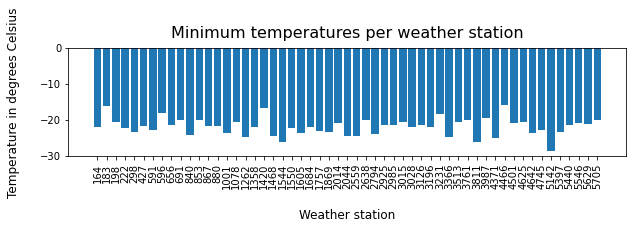

In [38]:
plot_min_max(selection.max().to_frame(), "Maximum")
plot_min_max(selection.min().to_frame(), "Minimum")

# Inspection of the selected weather stations

In [39]:
selection.head()

,164,183,198,222,298,427,591,596,656,691,...,4501,4625,4642,4745,5142,5397,5440,5546,5629,5705
MESS_DATUM,,,,,,,,,,,,,,,,,,,,,
1996-01-01 00:00:00,-10.8,-4.7,-6.6,-2.6,NaN,-9.7,-13.0,-10.5,-5.6,-7.6,...,-3.0,-13.1,-10.3,-9.6,-10.8,-5.6,-5.0,-10.2,-8.1,-1.7
1996-01-01 00:10:00,-10.9,-4.8,-6.6,-2.7,NaN,-9.7,-13.0,-10.7,-5.8,-7.5,...,-2.5,-13.1,-10.2,-9.6,-10.9,-5.6,-4.9,-10.2,-8.1,-1.8
1996-01-01 00:20:00,-11.0,-4.7,-6.6,-2.8,NaN,-9.7,-12.9,-10.7,-5.8,-7.6,...,-1.9,-13.0,-10.1,-9.6,-10.9,-5.6,-4.8,-10.2,-8.0,-1.9
1996-01-01 00:30:00,-11.0,-4.6,-6.6,-2.8,NaN,-9.6,-13.0,-10.7,-5.8,-7.6,...,-1.5,-12.9,-10.0,-9.7,-11.0,-5.6,-4.6,-10.2,-8.0,-1.9
1996-01-01 00:40:00,-10.9,-4.4,-6.6,-2.9,NaN,-9.6,-13.0,-10.7,-5.7,-7.6,...,-1.1,-12.8,-10.0,-9.8,-11.4,-5.6,-4.6,-10.2,-8.0,-2.0


## Distribution

In [40]:
number_of_stations = selection.shape[1]
number_of_stations

55

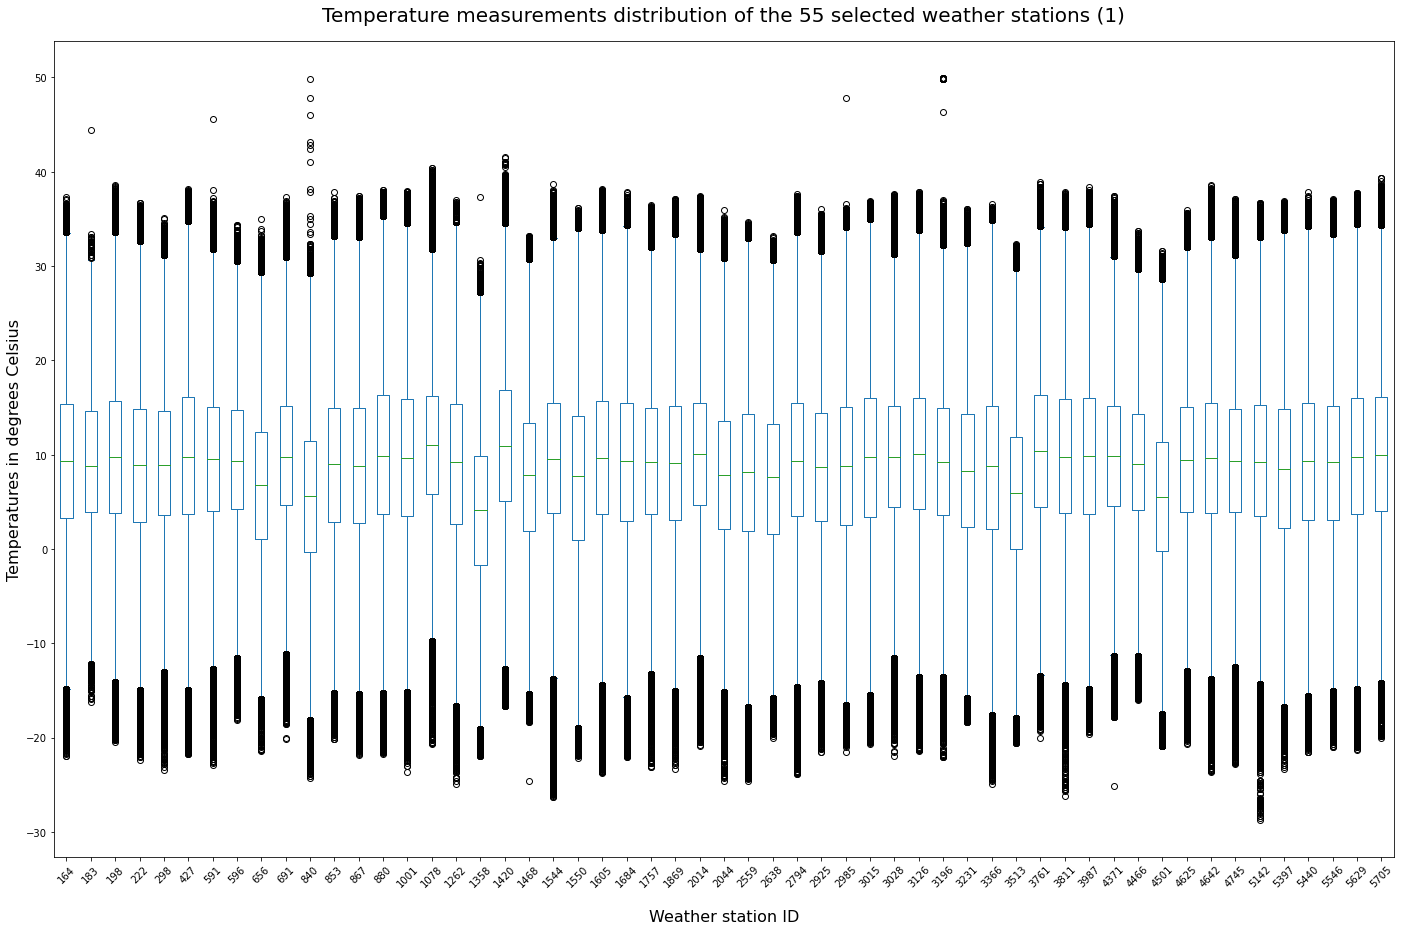

In [41]:
selection.plot.box(figsize=(24, 15))
plt.title("Temperature measurements distribution of the " 
          + str(number_of_stations) + " selected weather stations (1)",
          fontdict={"size": 20},
          pad=20)
plt.xlabel("Weather station ID", labelpad=20, fontsize=16)
plt.ylabel("Temperatures in degrees Celsius", fontsize=16)
plt.xticks(rotation=45);

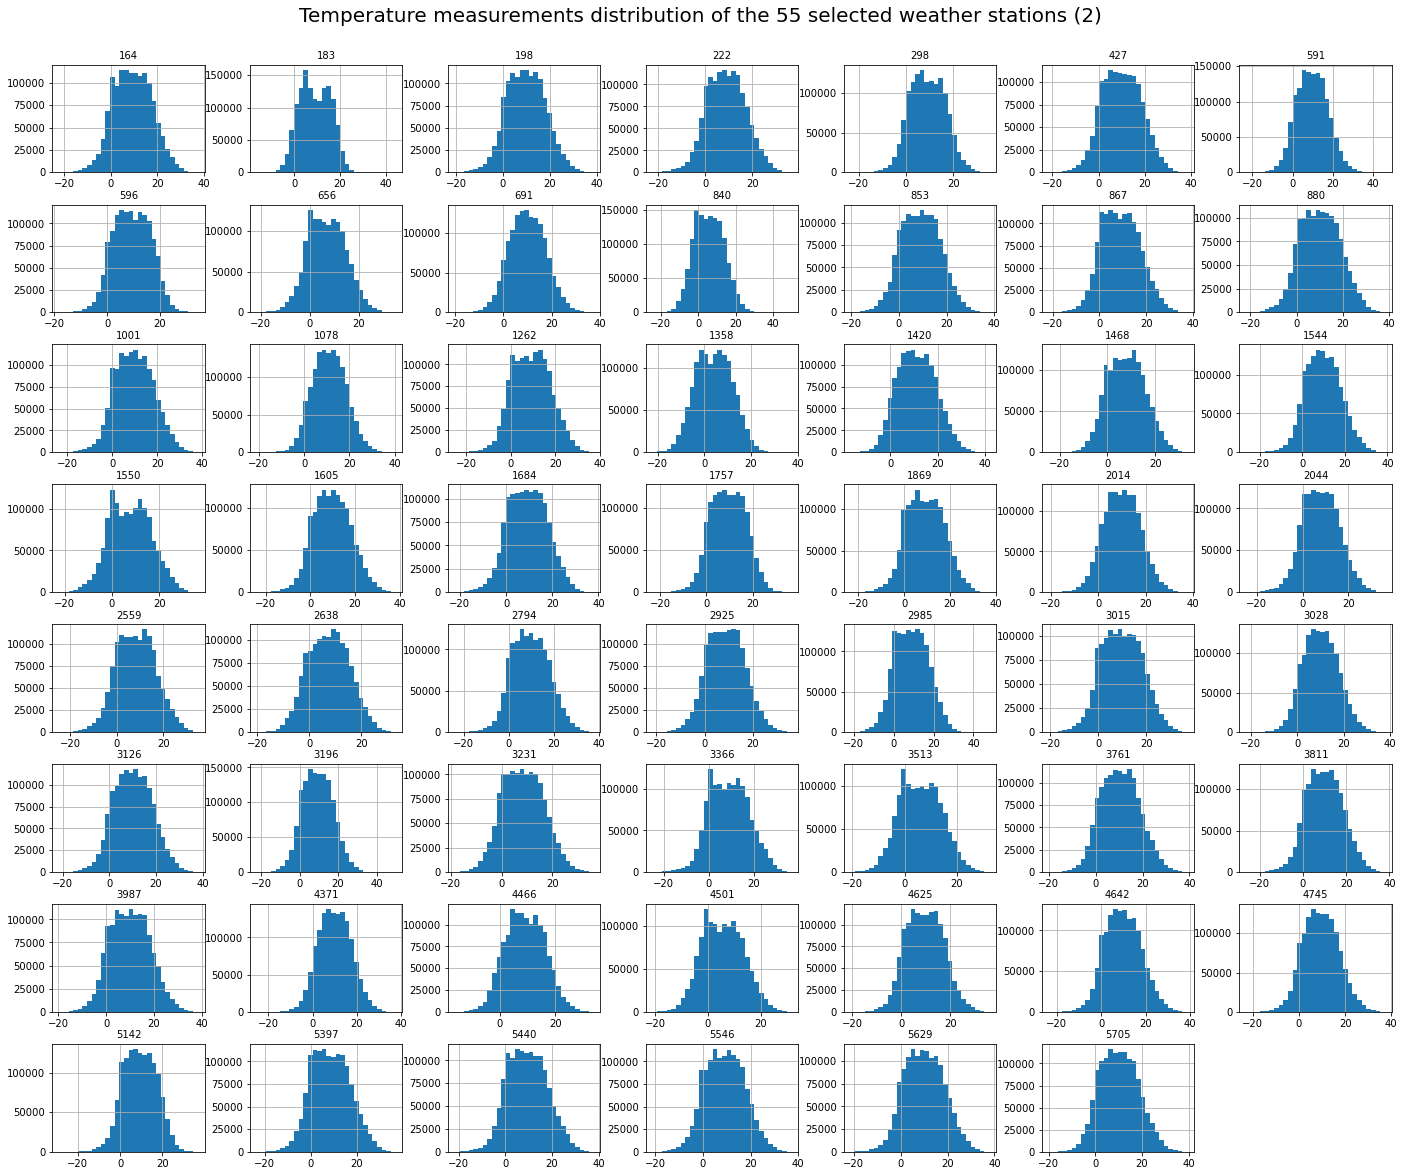

In [42]:
matplotlib.rcParams.update({'axes.titlesize':'10'})
selection.hist(bins=30, figsize=(24, 20))
suptitle_text = "Temperature measurements distribution of the " + str(number_of_stations) + " selected weather stations (2)"
plt.suptitle(suptitle_text, fontsize=20, y=0.92);

In [43]:
# compare the number of measurements per year for the original data and for the selection
sel_count = selection.groupby(selection.index.year).count().sum(axis=1) / 1000000
df_count = df.groupby(df.index.year).count().sum(axis=1) / 1000000

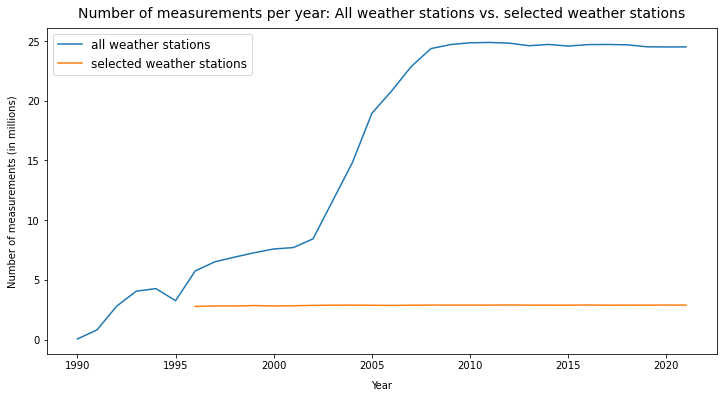

In [44]:
plt.figure(figsize=(12, 6))
df_count.plot()
sel_count.plot()
plt.title("Number of measurements per year: All weather stations vs. selected weather stations", 
          fontdict={"size" : 14}, pad=10)
plt.xlabel("Year", labelpad=10)
plt.ylabel("Number of measurements (in millions)", labelpad=10)
plt.legend(["all weather stations", "selected weather stations"], prop={'size': 12});

## Temperature increase

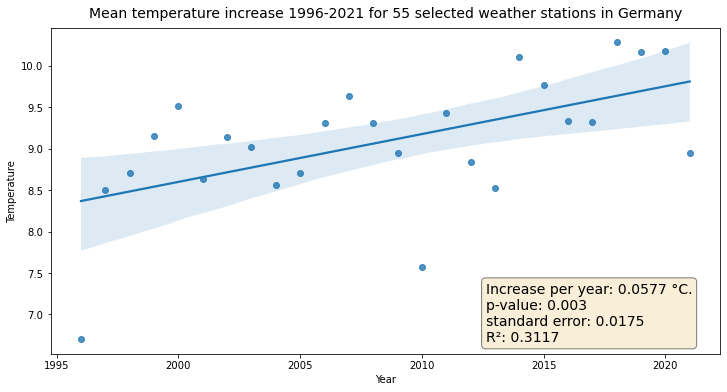

In [45]:
plot_result(selection)